<a href="https://colab.research.google.com/github/MarouaHY/LP_detection/blob/main/cnn_for_char_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# pretraitement d'une image d'un matricule

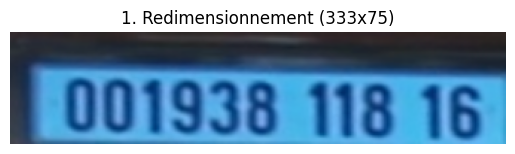

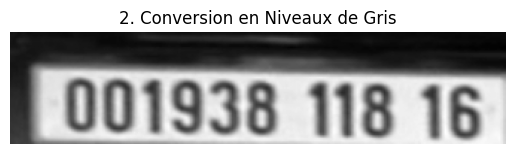

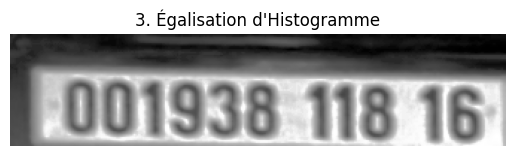

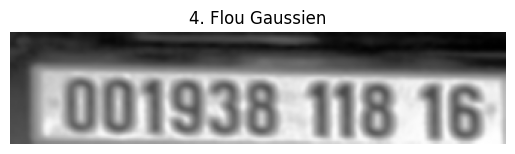

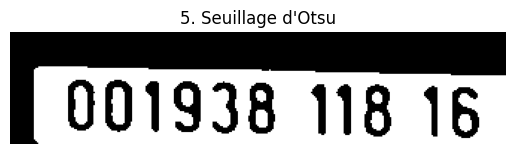

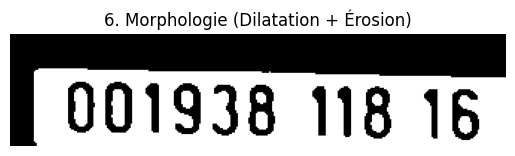

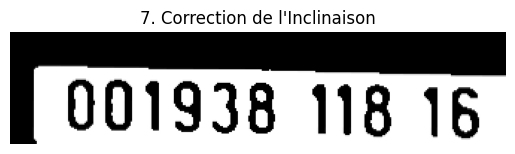

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    """ Fonction pour afficher une image avec matplotlib """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_plate(image_path):
    # Étape 1 : Lecture et redimensionnement
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (333, 75))
    show_image("1. Redimensionnement (333x75)", img_resized)

    # Étape 2 : Conversion en niveaux de gris
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    show_image("2. Conversion en Niveaux de Gris", gray)

    # Étape 3 : Égalisation d'histogramme
    gray_eq = cv2.equalizeHist(gray)
    show_image("3. Égalisation d'Histogramme", gray_eq)

    # Étape 4 : Flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)
    show_image("4. Flou Gaussien", blurred)

    # Étape 5 : Seuillage d'Otsu pour binarisation
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    show_image("5. Seuillage d'Otsu", thresh)

    # Étape 6 : Opérations morphologiques (dilatation puis érosion)
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    show_image("6. Morphologie (Dilatation + Érosion)", morphed)

    # Étape 7 : Correction de l'inclinaison
    edges = cv2.Canny(morphed, 50, 150)  # Détection des bords
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

    angle = 0.0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle += np.arctan2(y2 - y1, x2 - x1)

        angle /= len(lines)
        angle = np.degrees(angle)

        # Rotation de l'image pour corriger l'inclinaison
        (h, w) = morphed.shape
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        corrected = cv2.warpAffine(morphed, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        corrected = morphed  # Pas de correction si aucune ligne détectée

    show_image("7. Correction de l'Inclinaison", corrected)

    return corrected

# Exemple d'utilisation
preprocessed_image = preprocess_plate("/content/dataset/recognition/test/00193811816.jpg")


# segmentation des caracteres d'un matricule

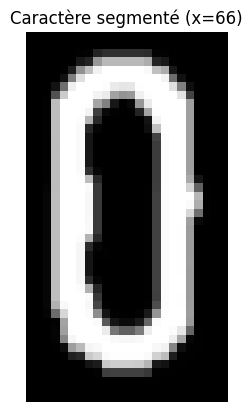

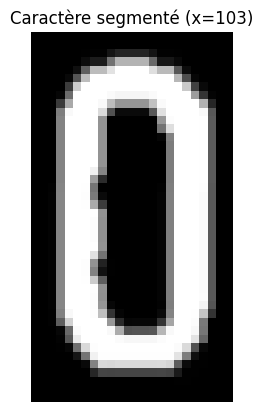

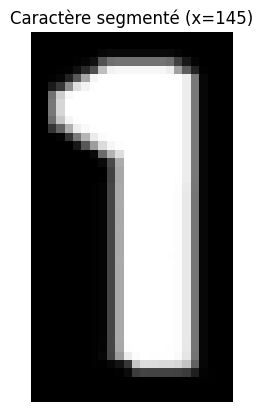

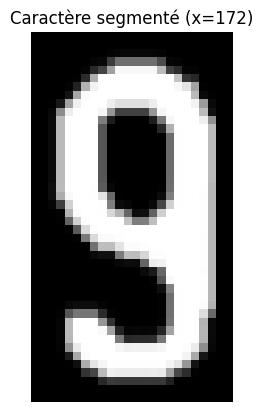

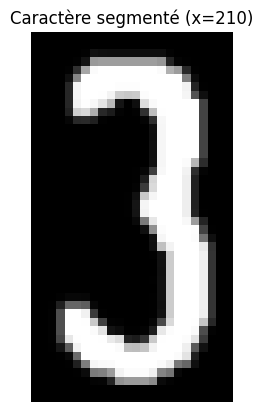

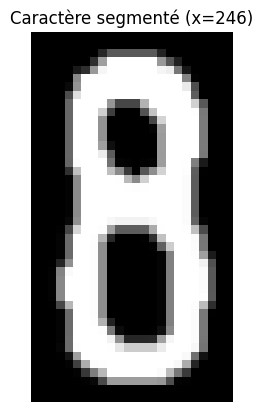

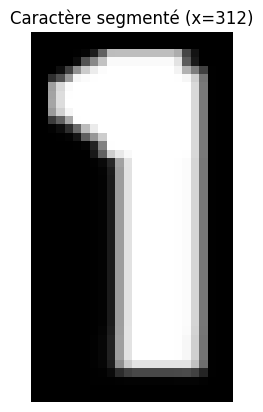

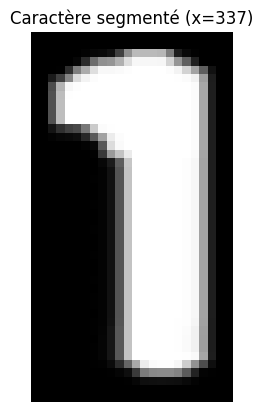

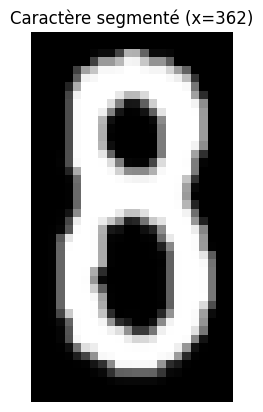

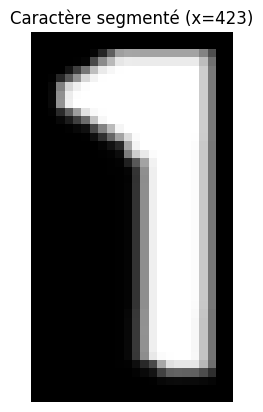

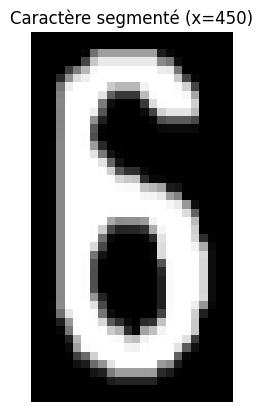

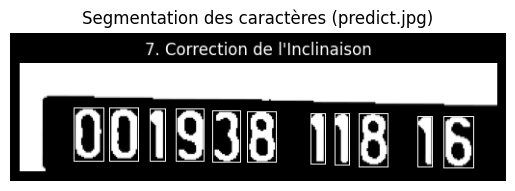

Nombre de caractères segmentés : 11


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    """Affiche une image avec matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def find_contours(dimensions, img):
    """Trouve les contours correspondant aux caractères."""
    # Détection des contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tri des contours par aire (du plus grand au plus petit)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Filtrage des contours par dimensions
    char_contours = []
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if dimensions[0] < h < dimensions[1] and dimensions[2] < w < dimensions[3]:
            char_contours.append((x, y, w, h))

    return char_contours

def segment_characters(plate_image):
    """Segmente les caractères d'une plaque d'immatriculation."""
    # Définition des dimensions attendues des caractères
    char_dimensions = (30, 70, 5, 40)  # (hauteur_min, hauteur_max, largeur_min, largeur_max)

    # Inversion des couleurs si nécessaire (blanc sur noir)
    if np.mean(plate_image) > 127:
        plate_image = cv2.bitwise_not(plate_image)

    # Trouver les contours des caractères
    char_contours = find_contours(char_dimensions, plate_image)

    # Extraire les caractères et les trier par coordonnée X
    char_contours = sorted(char_contours, key=lambda x: x[0])

    img_res = []

    for (x, y, w, h) in char_contours:
        # Extraire le caractère
        char = plate_image[y:y+h, x:x+w]

        # Redimensionner à 20x40 pixels
        char_resized = cv2.resize(char, (20, 40))

        # Ajouter une bordure noire pour obtenir 24x44 pixels
        char_padded = cv2.copyMakeBorder(char_resized, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        img_res.append(char_padded)

        # Affichage de chaque caractère segmenté
        show_image(f'Caractère segmenté (x={x})', char_padded)

    # Sauvegarde de l'image avec les contours dessinés pour visualisation
    output_image = plate_image.copy()
    for (x, y, w, h) in char_contours:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 1)

    cv2.imwrite('predict.jpg', output_image)
    show_image('Segmentation des caractères (predict.jpg)', output_image)

    return np.array(img_res)

# Exemple d'utilisation
plate_path = '/content/pp.png'
plate_image = cv2.imread(plate_path, cv2.IMREAD_GRAYSCALE)
segmented_chars = segment_characters(plate_image)

print(f'Nombre de caractères segmentés : {len(segmented_chars)}')


# modele CNN pour la reconnaissance des caracteres

Préparer les données

In [ ]:
# Cloner le repo (ça prend tout le repo)
!git clone https://github.com/faizan387/Car-Number-Plate-Recognition.git

# Accéder au dossier des données
import os
data_path = '/content/Car-Number-Plate-Recognition/Car plate recognition Punjab/data'
os.listdir(data_path)


Cloning into 'Car-Number-Plate-Recognition'...
remote: Enumerating objects: 1213, done.
remote: Counting objects: 100% (1213/1213), done.
remote: Compressing objects: 100% (1049/1049), done.
remote: Total 1213 (delta 160), reused 1202 (delta 154), pack-reused 0 (from 0)
Receiving objects: 100% (1213/1213), 1.35 MiB | 8.60 MiB/s, done.
Resolving deltas: 100% (160/160), done.


['validation', 'train']

Build the CNN model

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# CNN Model
def create_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Parameters
input_shape = (64, 64, 1)  # Update based on your image size
num_classes = 36  # 0-9 and A-Z

# Create the model
model = create_cnn_model(input_shape, num_classes)
model.summary()





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,146,532 (4.37 MB)

 Trainable params: 1,146,532 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

Entrainer et Evaluer le modèle

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 632ms/step - accuracy: 0.8886 - loss: 0.3456 - val_accuracy: 0.9630 - val_loss: 0.1145
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step - accuracy: 0.8918 - loss: 0.2945 - val_accuracy: 0.9630 - val_loss: 0.1036
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.8805 - loss: 0.3287 - val_accuracy: 0.9676 - val_loss: 0.1098
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 302ms/step - accuracy: 0.9076 - loss: 0.2358 - val_accuracy: 0.9815 - val_loss: 0.0680
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 366ms/step - accuracy: 0.8680 - loss: 0.3782 - val_accuracy: 0.9722 - val_loss: 0.0990
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.9041 - loss: 0.2789 - val_accuracy: 0.9630 - val_loss: 0.1200
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 297ms/step - accuracy: 0.9160 - loss: 0.2596 - val_accuracy: 0.9769 - val_loss: 0.0817
Epoch 8/

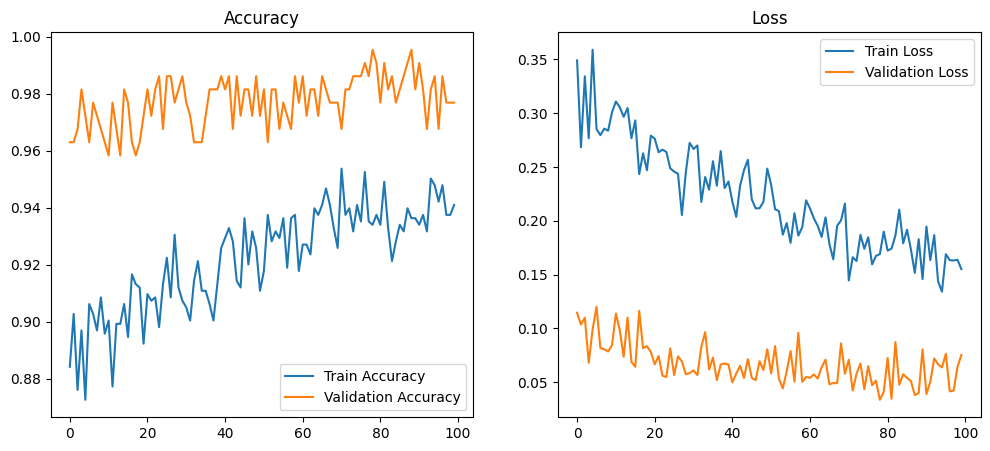

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Chemins des datasets
train_dir = '/content/Car-Number-Plate-Recognition/Car plate recognition Punjab/data/train'
val_dir = '/content/Car-Number-Plate-Recognition/Car plate recognition Punjab/data/validation'

# Prétraitement et augmentation des données
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

# Chargement des données
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Entraînement du modèle
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    verbose=1
)

# Visualisation des résultats
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


Enregistrer le modèle pré-entrainé

In [ ]:
model.save('/content/character_recognition_model.keras')



# Tester le modèle sur une image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras


1. prétraitement de l'image d'entré

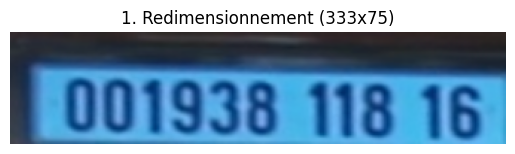

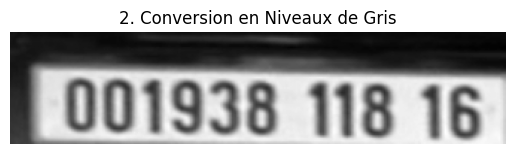

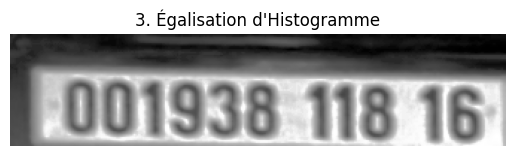

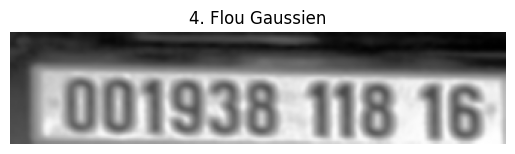

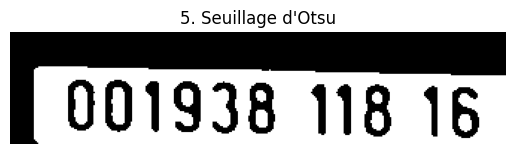

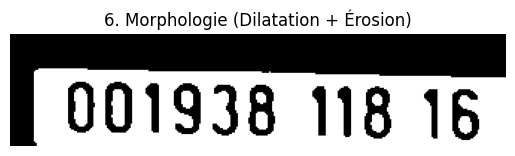

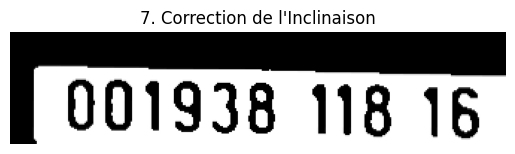

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    """ Fonction pour afficher une image avec matplotlib """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def preprocess_plate(image_path):
    # Étape 1 : Lecture et redimensionnement
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (333, 75))
    show_image("1. Redimensionnement (333x75)", img_resized)

    # Étape 2 : Conversion en niveaux de gris
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    show_image("2. Conversion en Niveaux de Gris", gray)

    # Étape 3 : Égalisation d'histogramme
    gray_eq = cv2.equalizeHist(gray)
    show_image("3. Égalisation d'Histogramme", gray_eq)

    # Étape 4 : Flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)
    show_image("4. Flou Gaussien", blurred)

    # Étape 5 : Seuillage d'Otsu pour binarisation
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    show_image("5. Seuillage d'Otsu", thresh)

    # Étape 6 : Opérations morphologiques (dilatation puis érosion)
    kernel = np.ones((3, 3), np.uint8)
    morphed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    show_image("6. Morphologie (Dilatation + Érosion)", morphed)

    # Étape 7 : Correction de l'inclinaison
    edges = cv2.Canny(morphed, 50, 150)  # Détection des bords
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50, minLineLength=50, maxLineGap=10)

    angle = 0.0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle += np.arctan2(y2 - y1, x2 - x1)

        angle /= len(lines)
        angle = np.degrees(angle)

        # Rotation de l'image pour corriger l'inclinaison
        (h, w) = morphed.shape
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, -angle, 1.0)
        corrected = cv2.warpAffine(morphed, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    else:
        corrected = morphed  # Pas de correction si aucune ligne détectée

    show_image("7. Correction de l'Inclinaison", corrected)

    return corrected

# Exemple d'utilisation
preprocessed_image = preprocess_plate("/content/dataset/recognition/test/00193811816.jpg")


2. Segmentation des caractères de l'image prétraitée

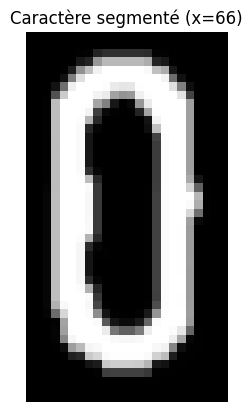

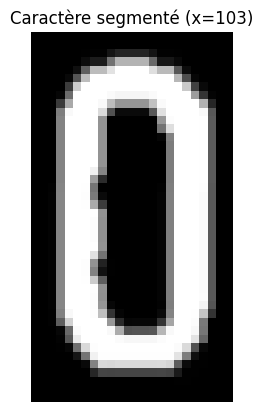

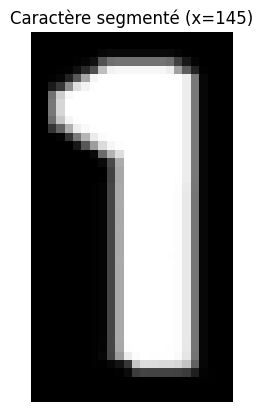

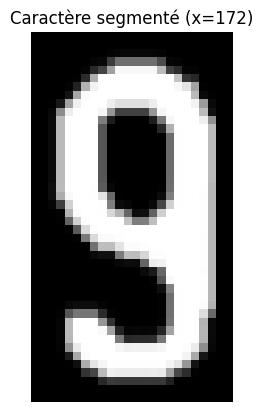

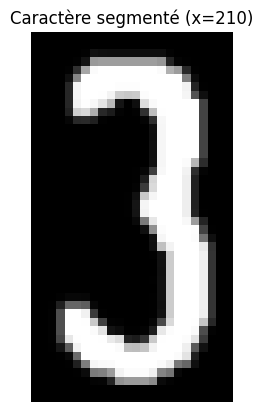

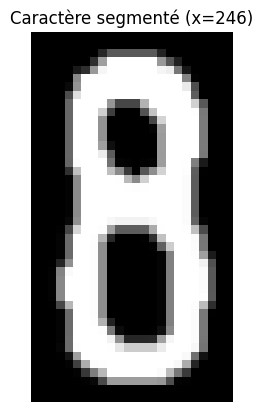

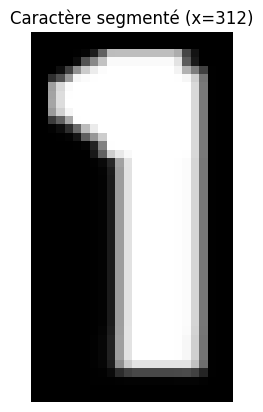

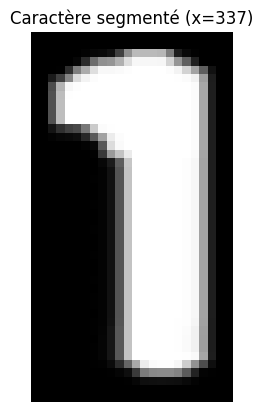

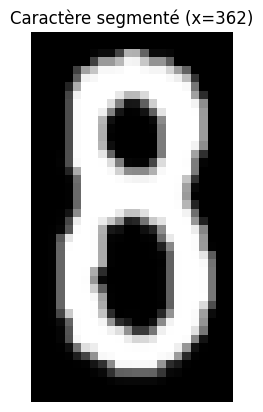

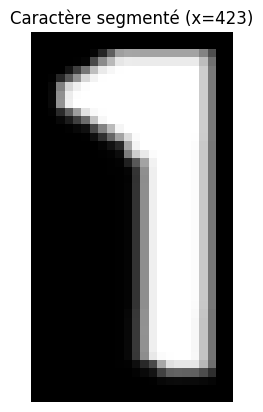

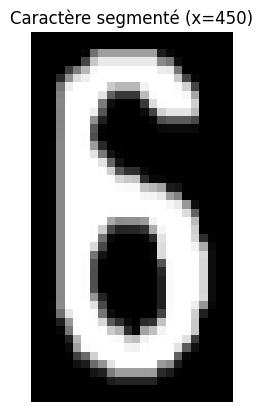

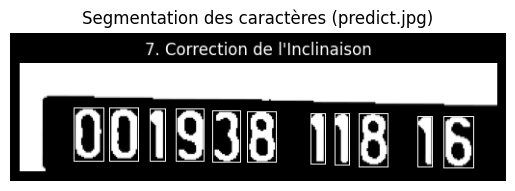

Nombre de caractères segmentés : 11


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, image):
    """Affiche une image avec matplotlib."""
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def find_contours(dimensions, img):
    """Trouve les contours correspondant aux caractères."""
    # Détection des contours
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tri des contours par aire (du plus grand au plus petit)
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Filtrage des contours par dimensions
    char_contours = []
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if dimensions[0] < h < dimensions[1] and dimensions[2] < w < dimensions[3]:
            char_contours.append((x, y, w, h))

    return char_contours

def segment_characters(plate_image):
    """Segmente les caractères d'une plaque d'immatriculation."""
    # Définition des dimensions attendues des caractères
    char_dimensions = (30, 70, 5, 40)  # (hauteur_min, hauteur_max, largeur_min, largeur_max)

    # Inversion des couleurs si nécessaire (blanc sur noir)
    if np.mean(plate_image) > 127:
        plate_image = cv2.bitwise_not(plate_image)

    # Trouver les contours des caractères
    char_contours = find_contours(char_dimensions, plate_image)

    # Extraire les caractères et les trier par coordonnée X
    char_contours = sorted(char_contours, key=lambda x: x[0])

    img_res = []

    for (x, y, w, h) in char_contours:
        # Extraire le caractère
        char = plate_image[y:y+h, x:x+w]

        # Redimensionner à 20x40 pixels
        char_resized = cv2.resize(char, (20, 40))

        # Ajouter une bordure noire pour obtenir 24x44 pixels
        char_padded = cv2.copyMakeBorder(char_resized, 2, 2, 2, 2, cv2.BORDER_CONSTANT, value=(0, 0, 0))

        img_res.append(char_padded)

        # Affichage de chaque caractère segmenté
        show_image(f'Caractère segmenté (x={x})', char_padded)

    # Sauvegarde de l'image avec les contours dessinés pour visualisation
    output_image = plate_image.copy()
    for (x, y, w, h) in char_contours:
        cv2.rectangle(output_image, (x, y), (x + w, y + h), (255, 0, 0), 1)

    cv2.imwrite('predict.jpg', output_image)
    show_image('Segmentation des caractères (predict.jpg)', output_image)

    return np.array(img_res)

# Exemple d'utilisation
plate_path = '/content/pp.png'
plate_image = cv2.imread(plate_path, cv2.IMREAD_GRAYSCALE)
segmented_chars = segment_characters(plate_image)

print(f'Nombre de caractères segmentés : {len(segmented_chars)}')


3. Appliquer le CNN sur les caractères segmentés et afficher le matricule

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Charger le modèle
model = load_model('/content/character_recognition_model.keras')

# Normaliser les images et faire les prédictions
predicted_labels = []

# Taille d'entrée attendue par le modèle
input_height, input_width = 64, 64

for char_img in segmented_chars:
    # Redimensionner le caractère segmenté à (64, 64)
    char_img_resized = cv2.resize(char_img, (input_width, input_height))

    # Normalisation : pixels entre 0 et 1
    char_img_resized = char_img_resized / 255.0

    # Ajout d'une dimension pour le batch et le canal
    char_img_resized = np.expand_dims(char_img_resized, axis=0)  # (1, h, w)
    char_img_resized = np.expand_dims(char_img_resized, axis=-1)  # (1, h, w, 1)

    # Prédiction
    prediction = model.predict(char_img_resized)
    predicted_label = np.argmax(prediction, axis=1)[0]
    predicted_labels.append(predicted_label)

# Affichage du résultat
plate_number = ''.join(map(str, predicted_labels))
print("Numéro de la plaque :", plate_number)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Numéro de la plaque : 00193811816
